In [ ]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate();

# Question 2: Balancing a Quadruped (35 pts)
In this problem we'll use what we learned about equilibria and basic unconstrained optimization to find a joint configuration that balances a quadruped on one leg. 
We provide you methods to evaluate the dynamics and the dynamics Jacobians, along with a reasonable initial guess. It's your job to find a set of joint configurations and torques to stabilize the quadruped on one leg.

Your final result should look something like this:

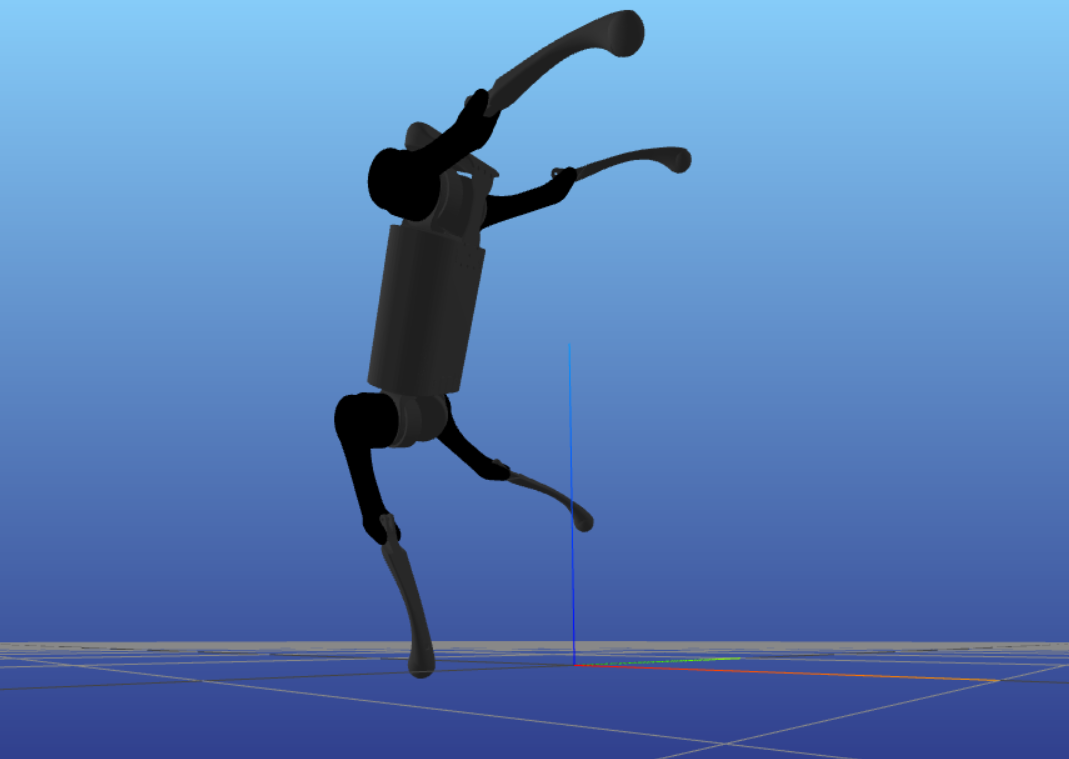

In [ ]:
include("quadruped.jl");  # a handful of methods for working with the quadruped

In [ ]:
# Load in the Robot model
model = UnitreeA1()

# Open up a visualizer
mvis = initialize_visualizer(model)
render(mvis)

Use these commands as a reference for evaluating the dynamics and their Jacobians. Underneath the hood we're using [RigidBodyDynamics.jl](https://github.com/JuliaRobotics/RigidBodyDynamics.jl) and [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl).

*Note*: It may take a few seconds to load this cell the first time, thanks to JIT. 

In [ ]:
# Set initial configuration and evaluate the dynamics
x_guess = initial_state(model)
set_configuration!(mvis, x_guess[1:state_dim(model)÷2])

# Evaluate the continuous dynamics
u = zeros(12)
xdot = dynamics(model, x_guess, u)

# Evaluate the continuous dynamics Jacobian
∇f = jacobian(model, x_guess, u)

norm(xdot)  # we want this to be zero!

## Part a: KKT Conditions (10 pts)
To achieve our goal of finding an equilibrum state for standing on one leg, we will solve the following unconstrained optimization problem:
$$
\begin{align}
& \text{minimize}_{x,u} && \frac{1}{2} (x-x_\text{guess})^T (x-x_\text{guess}) + 0.5e^{-3} u^T u \\
& \text{subject to} && f(x,u) = 0
\end{align}
$$

We will use Newton's method to solve this optimization problem. The first step in solving an optimization problem is to derive the optimality conditions. Derive the 1st order optimality conditions, i.e. the KKT conditions. Then complete the function below to evaluate the KKT conditions:

In [ ]:
# TASK: Implement this function (5 pts)
"""
    kkt_conditions(model, x, u, λ, A, B)

Evaluate the KKT conditions for the optimization problem in Part(a). The `model` provides access to the dynamics and the initial state (see above).
The KKT conditions are evaluated with states `x`, controls `u` and Lagrange multipliers `λ`. The `A` and `B` matrices are the continuous-time dynamics Jacobians.
"""
function kkt_conditions(model::UnitreeA1, x, u, λ, A, B)
    # Get initial state from the model (if you need it)
    x_guess = initial_state(model)
    
    # TODO: Fill out these lines
    ∇ₓL = zero(x)
    ∇ᵤL = zero(u)
    c = zero(x)
    
    # Return the concatenated vector
    return [∇ₓL; ∇ᵤL; c]
end

Note that we want the output of this function to be zero. We will use Newton's method to find a root of this function. To do this, we will need the Jacobian of the KKT conditions. Taking the full Newton step on this step would require 2nd order derivatives of our dynamics, which are computationally prohibitive to compute, and often unnecessary, as we will see. Instead we will use the "Gauss-Newton" approximation. When computing the Jacobian below, don't differentiate any terms containing $A$ or $B$ with respect to $x$ or $u$.

In [ ]:
# TASK: Complete this function (5 pts)
"""
    kkt_jacobian(model, x, u, λ, A, B, [ρ])

Form the Jacobian of the KKT conditions. Uses a Gauss-Newton approximation to avoid 2nd order derivatives of the dynamics.
Evaluated at states `x`, controls `u`, Lagrange multipliers `λ`, provided the dynamics Jacobians `A` and `B`.

The optional parameter `ρ` can be used to add regularization to the KKT system (recommended). 
This should be applied along the diagonal of the KKT system, and should be positive for primal variables and negative for dual variables.
For example: `Hreg = H + Diagonal([ones(n+m); -ones(n)])*ρ`.
"""
function kkt_jacobian(model::UnitreeA1, x, u, λ, A, B, ρ=1e-5)
    # HINT: You may find these ranges to be helpful
    parts = get_partition(model)
    ix = parts[1]     # state variables
    iu = parts[2]     # control variables
    ic = parts[3]     # constraints
    n = length(ix)    # number of states
    m = length(iu)    # number of controls
    
    # TODO: Create the KKT matrix
    H = zeros(2n+m, 2n+m)
    
    return Symmetric(H)
end

## Part b: Use Newton's method (20 pts)
Use Newton's method and the methods you just wrote down to find an equilibrium point for the quadruped balancing on one leg. Your method should converge to a point where the 2-norm of the KKT conditions is less that 1e-6. It should take less than 50 iterations (less than 20 after a little bit of tuning on the regularization).

**NOTE**: You are allowed to use a simple Newton's method without any globalization techniques such as line searches, adaptive regularization, or second-order corrections. A fixed regularizer and full Newton steps at each iterations should converge. It may not monotonically decrease the residual norm, but it should converge to the specified tolerance within a reasonable number of iterations.

**NOTE**: To visualize the result at each iteration, you'll need to implement make use of the optional `mvis` argument. You can copy and paste this code into your solver (it's up to you to decide where). You're also welcome to change the sleep time.
```julia
if !isnothing(mvis)
    set_configuration!(mvis, x[1:15])
    sleep(0.1)
end
```
Then to plot the iterations you'll call it with the extra argument (`mvis` is already defined above): `newton_method(model, x_guess, mvis)`.

In [ ]:
# TASK: Complete the following function
using Printf
"""
    newton_solve(model, x_guess, [mvis; verbose])

Use Newton's method to find an equilibrium point for the quadruped, starting at `x_guess`. 
Should return the optimal states, controls, and Lagrange multipliers, along with the vector
of 2-norm residuals for each iteration.

# Optional Arguments
* `mvis`: Pass in a MechanismVisualizer to visualize the iterations in a MeshCat window
* `verbose`: flag to print out solver iterations
* `max_iters`: maximum number of solver iterations
* `ρ`: regularization
"""
function newton_solve(model::UnitreeA1, x_guess, mvis=nothing; verbose=true, max_iters=50, ρ=1e-3)
    u = zeros(12)
    x = copy(x_guess) 
    λ = zero(x_guess)
    ix,iu,ix2 = get_partition(model)

    # TODO: Finish the function
    res_hist = Float64[]
    return x,u,λ, res_hist
end
render(mvis)

In [ ]:
xstar, ustar, λstar = newton_solve(model, x_guess, mvis);

## Part (c): Stability Analysis (5 pts)
Show that this balancing equilibrium is, in fact, in equilibrium, and that it is unstable by evaluating the eigenvalues of $\frac{\partial f}{\partial x}|_{x^*,u^*}$

In [ ]:
# TASK: compute the variables `final_residual::Real` (2 pts) and `eigs::Vector{<:Number}` (3 pts)

# Calculate the final dynamics residual (2-norm) to verify it is an equilibrium point
@show final_residual = NaN

# Calculate the eigenvalues of the state transition matrix and verify it is unstable
eigs = zeros(Complex{Float64},30)

## Extra Credit: Globalization Strategies (5 pts)
You might have noticed that the residual doesn't decrease monotonically during your Newton solve, and can take a large number of iterations if you don't have the regularization tuned just right. As discussed in class, there are many methods for improving Newton's method when it's operating far from the locall minima (i.e. globalization methods). Get some extra credit by implementing one of these methods and show that it decreases the number of iterations required by the Newton solver.

**HINT**: For ease of comparison, pass in an optional flag (maybe a `Symbol`) to `newton_solve` that allows you to turn on/off your globalization method or pick among a couple options.